# pymc3 sampling

This notebook illustrates how pymc3 can be used with an arbitrary (in our case: AMICI) log likelihood function in pyPESTO.

In [13]:
import petab
import pypesto

petab_problem = petab.Problem.from_yaml("conversion_reaction/conversion_reaction.yaml")
importer = pypesto.PetabImporter(petab_problem)

problem = importer.create_problem()
problem.x_names

['k1', 'k2']

In [14]:
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt

In [31]:
class PosteriorTheano(tt.Op):
    """
    Theano implementation of the posterior
    """
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)


    def __init__(self, objective):
        self.objective = objective

    def perform(self, node, inputs, outputs):
        theta, = inputs
        llh = - self.objective(theta, sensi_orders=(0,))
        outputs[0][0] = np.array(llh)

In [37]:
# create our Op
logl = PosteriorTheano(problem.objective)

ndraws = 500  # number of draws from the distribution
nburn = 50   # number of "burn-in points" (which we'll discard)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
    k1 = pm.Uniform('k1', lower=-5, upper=5.)
    k2 = pm.Uniform('k2', lower=-5, upper=5.)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([k1, k2])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [k2]
>Slice: [k1]
Sampling 2 chains, 0 divergences: 100%|██████████| 1100/1100 [00:26<00:00, 41.46draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


-0.2231435513142097 -0.5108256237659907


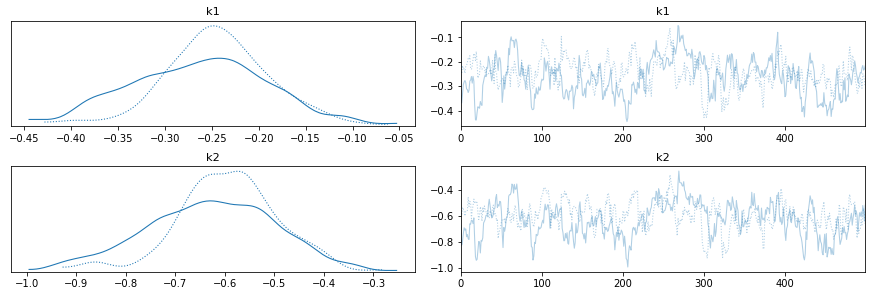

In [39]:
k1_true, k2_true = np.log(0.8), np.log(0.6)
print(k1_true, k2_true)

# plot the traces
_ = pm.traceplot(trace, lines={'k1': k1_true, 'k2': k2_true})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f152a028d10>,
      dtype=object)

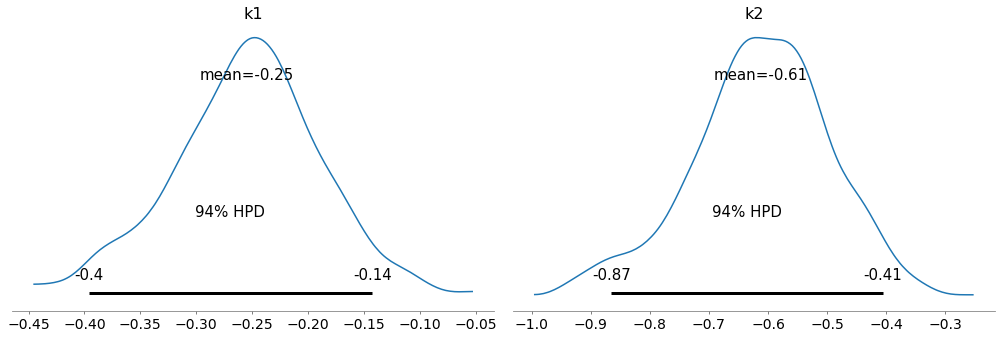

In [40]:
pm.plot_posterior(trace)